# Setup
Install and import required packages 
Extract data if it has not already been extracted

In [1]:
# Cell 1

# Uncomment the line below if there are some packages missing
#!pip install -r ../requirements.txt

In [2]:
# Cell 2
import warnings
warnings.filterwarnings('ignore')

import pandas_plink as pp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import subprocess
import pandas as pd
import numpy as np
from functools import reduce
from sklearn.metrics import r2_score
import random
import os
import tarfile
import gzip
from tools import *

################################################################
# Uncomment the line below if the files required are missing
# extract_data()
################################################################
%load_ext autoreload
%autoreload 2

# Ensuring correct installation and setup of plink2

In [3]:
# Cell 3

# IF RUNNING THIS RESULTS IN THE ERROR MESSAGE:
# /bin/bash: ./plink2: Permission denied
# UNCOMMENT THE LINE OF CODE BELOW THIS AND RERUN THE CELL THEN RECOMMENT

#######################################
#!chmod 700 plink2
#!chmod 700 plink
#######################################

# OTHERWISE, SHOULD OUTPUT SOMETHING LIKE 
"""
PLINK v2.0.0-a.6 32-bit (20 Oct 2024)              cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3

  plink2 <input flag(s)...> [command flag(s)...] [other flag(s)...]
  plink2 --help [flag name(s)...]

Commands include --rm-dup list, --make-bpgen, --export, --freq, --geno-counts,
--sample-counts, --missing, --hardy, --het, --fst, --indep-pairwise,
--r2-phased, --sample-diff, --make-king, --king-cutoff, --pmerge, --pgen-diff,
--write-samples, --write-snplist, --make-grm-list, --pca, --glm, --adjust-file,
--gwas-ssf, --pheno-svd, --clump, --score-list, --variant-score,
--genotyping-rate, --pgen-info, --validate, and --zst-decompress.

"plink2 --help | more" describes all functions.

"""
!./plink2


PLINK v2.0.0-a.6 32-bit (20 Oct 2024)              cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3

  plink2 <input flag(s)...> [command flag(s)...] [other flag(s)...]
  plink2 --help [flag name(s)...]

Commands include --rm-dup list, --make-bpgen, --export, --freq, --geno-counts,
--sample-counts, --missing, --hardy, --het, --fst, --indep-pairwise,
--r2-phased, --sample-diff, --make-king, --king-cutoff, --pmerge, --pgen-diff,
--write-samples, --write-snplist, --make-grm-list, --pca, --glm, --adjust-file,
--gwas-ssf, --pheno-svd, --clump, --score-list, --variant-score,
--genotyping-rate, --pgen-info, --validate, and --zst-decompress.

"plink2 --help | more" describes all functions.


# Loading data

In [4]:
# Cell 4
phenotype_data = '../data/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz'

# alleles = .bim (snp. came from vcf file (txt file))
# samples = .fam (family id)
# genotypes = .bed (genotypes). Rows and columns defined by alleles and samples
(alleles, samples, genotypes) = pp.read_plink("../data/LDREF/1000G.EUR.*",
                             verbose=False)
genotypes = pd.DataFrame(genotypes.compute())
P = pd.read_csv(phenotype_data, sep='\t', compression='gzip')


#

# Training PRS models for genes related to cardiovascular diseases 

In [5]:
cardio_vascular_genes = {
    "MYH7": "ENSG00000092054",
    "NOS3": "ENSG00000164867",
    "ACE": "ENSG00000159640",
    "PPARG": "ENSG00000132170"
}
# Not all genes are present in the dataset
cv_genes = get_genes(cardio_vascular_genes.values(), P)

# cis-eQTL analysis and PRS distribution with cross validation for each gene
# Results may vary slightly due to SNP pruning and thresholding methods
all_model_results = {}
for cvg in cv_genes:
    cv_prs_model_results = generate_prs([cvg], alleles, samples, genotypes, P, [1, 0.05, 0.01, 0.001, 0.00001], [0.1, 0.2, 0.3, 0.4, 0.5], train_size=0.6, valid_size=0.3)
    all_model_results[cvg] = cv_prs_model_results    
model_performances = {k: {**v['r2_scores'], **v['hyperparams']} for k,v in all_model_results.items()}
pd.DataFrame().from_dict(model_performances, orient='index')

,train_r2,valid_r2,test_r2,beta_p_val,ld_r2_thresh
ENSG00000132170.15,0.135937,0.131482,0.158472,0.001,0.3
ENSG00000159640.8,0.060060,0.076451,0.257734,1.000,0.1
ENSG00000092054.11,0.209140,0.184672,0.047781,1.000,0.2
ENSG00000164867.5,0.137610,0.045621,0.066265,1.000,0.1


# Null models

In [6]:
all_random_results = {}
for cvg in cv_genes:
    cv_prs_model_results = generate_prs([cvg], alleles, samples, genotypes, P, [1, 0.05, 0.01, 0.001, 0.00001], [0.1, 0.2, 0.3, 0.4, 0.5], train_size=0.6, valid_size=0.3, compare_random=True)
    all_random_results[cvg] = cv_prs_model_results    
random_model_performances = {k: {**v['r2_scores'], **v['hyperparams']} for k,v in all_random_results.items()}
pd.DataFrame().from_dict(random_model_performances, orient='index')

,train_r2,valid_r2,test_r2,beta_p_val,ld_r2_thresh
ENSG00000132170.15,0.130058,0.059780,0.000050,1.00,0.5
ENSG00000159640.8,0.047725,0.053285,0.011355,1.00,0.1
ENSG00000092054.11,0.001248,0.114376,0.011699,0.05,0.3
ENSG00000164867.5,0.003824,0.105089,0.029814,0.01,0.4


# PRS distribution of a single CVD gene

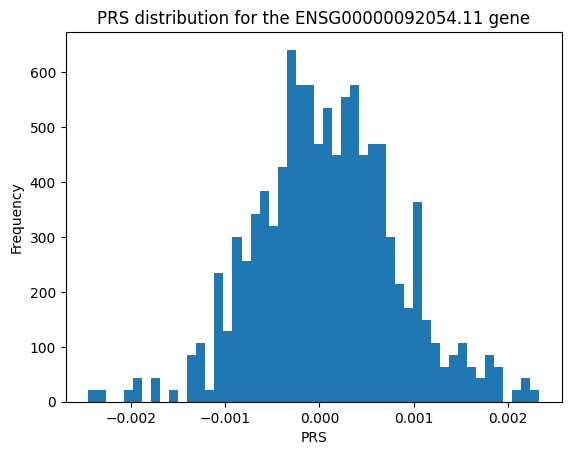

In [7]:
# PRS of Individual sample from 23andMe data w.r.t PRS distribution
sample_vcf_fp = '../data/f_eur_sample.vcf'

temp_gene = 'ENSG00000092054.11'

#sample_prs = vcf_to_prs(sample_vcf_fp, all_model_results[temp_gene]['eqtl_analysis'])
plt.hist(all_model_results[temp_gene]['prs_model'].values(), bins=50, density=True)
plt.title(f'PRS distribution for the {temp_gene} gene')
plt.xlabel('PRS')
plt.ylabel('Frequency')
plt.show()

# Expression level distribution of a single CVD gene

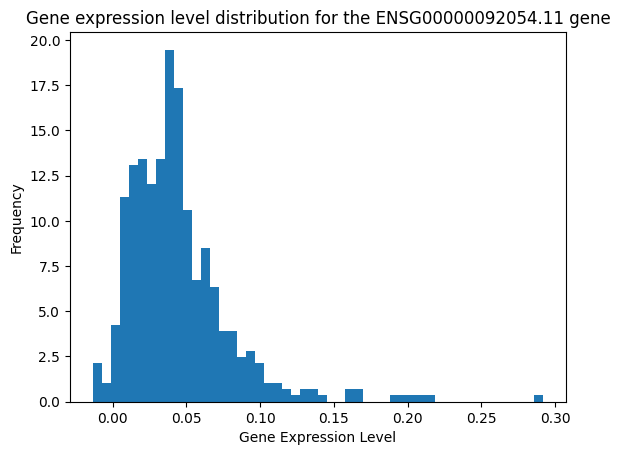

In [8]:
P[P['TargetID']==temp_gene][P.columns[4:]].reset_index(drop=True).T[0].plot(kind='hist', bins=50, density=True)
plt.xlabel('Gene Expression Level')
plt.title(f'Gene expression level distribution for the {temp_gene} gene')
plt.show()

# Training PRS models for genes related to type 1 diabetes

In [9]:
diabetes_1_genes = {
    'HLA-DQA1':'ENSG00000196735',
    'HLA-DQB1': 'ENSG00000179344',
    'HLA-DRB1': 'ENSG00000196126'
}
# Not all genes are present in the dataset
d1_genes = get_genes(diabetes_1_genes.values(), P)

# cis-eQTL analysis and PRS distribution with cross validation for each gene
# Results may vary slightly due to SNP pruning and thresholding methods
all_model_results = {}
for dg in d1_genes:
    d_prs_model_results = generate_prs([dg], alleles, samples, genotypes, P, [1, 0.05, 0.01, 0.001, 0.00001], [0.1, 0.2, 0.3, 0.4, 0.5], train_size=0.6, valid_size=0.3)
    all_model_results[dg] = d_prs_model_results    
model_performances = {k: {**v['r2_scores'], **v['hyperparams']} for k,v in all_model_results.items()}
pd.DataFrame().from_dict(model_performances, orient='index')

,train_r2,valid_r2,test_r2,beta_p_val,ld_r2_thresh
ENSG00000196126.6,0.339999,0.452667,0.581211,0.00100,0.5
ENSG00000196735.6,0.389062,0.482005,0.424194,0.00001,0.1
ENSG00000179344.11,0.573505,0.602235,0.454966,0.00100,0.4


# Null models

In [10]:
all_random_results = {}
for dg in d1_genes:
    d_prs_model_results = generate_prs([dg], alleles, samples, genotypes, P, [1, 0.05, 0.01, 0.001, 0.00001], [0.1, 0.2, 0.3, 0.4, 0.5], train_size=0.6, valid_size=0.3, compare_random=True)
    all_random_results[dg] = d_prs_model_results    
random_model_performances = {k: {**v['r2_scores'], **v['hyperparams']} for k,v in all_random_results.items()}
pd.DataFrame().from_dict(random_model_performances, orient='index')

,train_r2,valid_r2,test_r2,beta_p_val,ld_r2_thresh
ENSG00000196126.6,0.020095,0.244242,0.012155,0.05,0.3
ENSG00000196735.6,0.058665,0.190181,0.026279,0.05,0.5
ENSG00000179344.11,0.159239,0.347850,0.114793,1.00,0.2


# PRS distribution of a single T1D gene

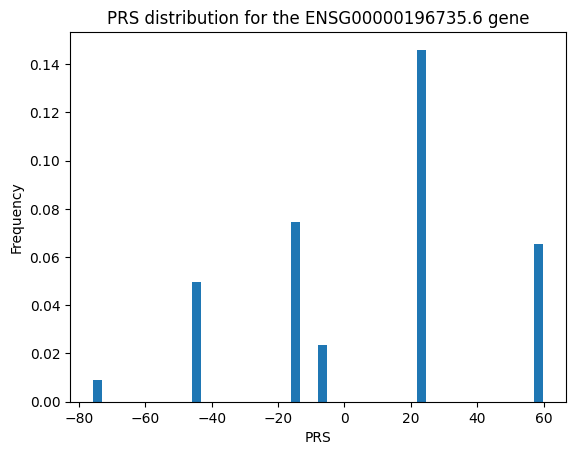

In [11]:
temp_gene = 'ENSG00000196735.6'

sample_prs = vcf_to_prs(sample_vcf_fp, all_model_results[temp_gene]['eqtl_analysis'])
plt.hist(all_model_results[temp_gene]['prs_model'].values(), bins=50, density=True)
plt.title(f'PRS distribution for the {temp_gene} gene')
plt.xlabel('PRS')
plt.ylabel('Frequency')
plt.show()

# Expression level distribution of a single T1D gene

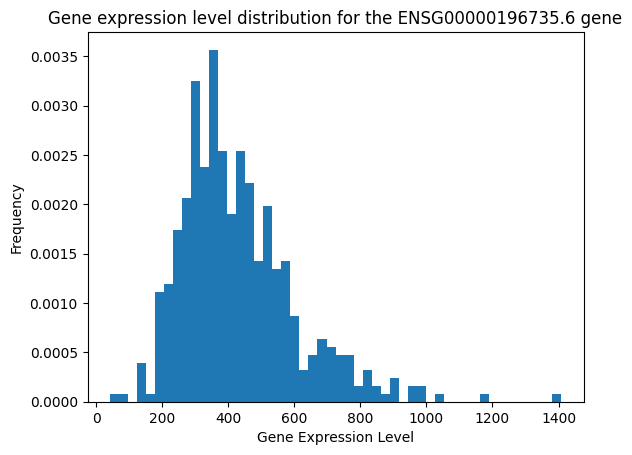

In [12]:
P[P['TargetID']==temp_gene][P.columns[4:]].reset_index(drop=True).T[0].plot(kind='hist', bins=50, density=True)
plt.xlabel('Gene Expression Level')
plt.title(f'Gene expression level distribution for the {temp_gene} gene')
plt.show()

# Training PRS models for genes related to type 2 diabetes

In [13]:
diabetes_2_genes = {
    'TCF7L2':'ENSG00000148737',
    'HMGA1': 'ENSG00000137309',
    'CDKAL1': 'ENSG00000145996'
}
# Not all genes are present in the dataset
d2_genes = get_genes(diabetes_2_genes.values(), P)

# cis-eQTL analysis and PRS distribution with cross validation for each gene
# Results may vary slightly due to SNP pruning and thresholding methods
all_model_results = {}
for dg in d2_genes:
    d_prs_model_results = generate_prs([dg], alleles, samples, genotypes, P, [1, 0.05, 0.01, 0.001, 0.00001], [0.1, 0.2, 0.3, 0.4, 0.5], train_size=0.6, valid_size=0.3)
    all_model_results[dg] = d_prs_model_results    
model_performances = {k: {**v['r2_scores'], **v['hyperparams']} for k,v in all_model_results.items()}
pd.DataFrame().from_dict(model_performances, orient='index')

,train_r2,valid_r2,test_r2,beta_p_val,ld_r2_thresh
ENSG00000137309.14,0.009157,0.017364,0.012922,1,0.1
ENSG00000148737.11,0.098208,0.244599,0.020519,1,0.5
ENSG00000145996.7,0.070195,0.142683,0.163833,1,0.1


# Null models

In [14]:
all_random_results = {}
for dg in d2_genes:
    d_prs_model_results = generate_prs([dg], alleles, samples, genotypes, P, [1, 0.05, 0.01, 0.001, 0.00001], [0.1, 0.2, 0.3, 0.4, 0.5], train_size=0.6, valid_size=0.3, compare_random=True)
    all_random_results[dg] = d_prs_model_results    
random_model_performances = {k: {**v['r2_scores'], **v['hyperparams']} for k,v in all_random_results.items()}
pd.DataFrame().from_dict(random_model_performances, orient='index')

,train_r2,valid_r2,test_r2,beta_p_val,ld_r2_thresh
ENSG00000137309.14,0.022668,0.003196,0.008720,0.05,0.1
ENSG00000148737.11,0.026818,0.057919,0.028592,0.01,0.4
ENSG00000145996.7,0.011994,0.076609,0.000450,1.00,0.3


# PRS distribution of a single T2D gene

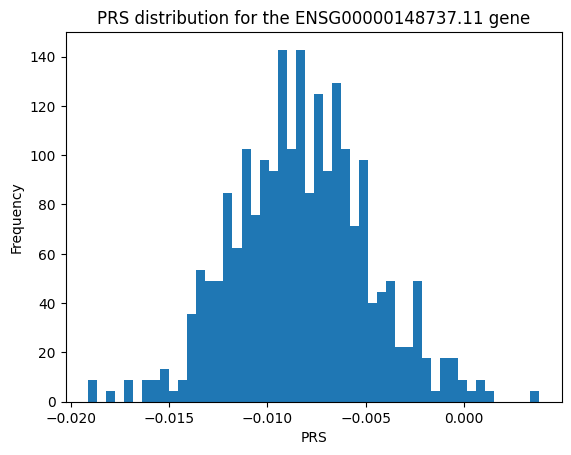

In [15]:
temp_gene = 'ENSG00000148737.11'

sample_prs = vcf_to_prs(sample_vcf_fp, all_model_results[temp_gene]['eqtl_analysis'])
plt.hist(all_model_results[temp_gene]['prs_model'].values(), bins=50, density=True)
plt.title(f'PRS distribution for the {temp_gene} gene')
plt.xlabel('PRS')
plt.ylabel('Frequency')
plt.show()

# Expression level distribution of a single T1D gene

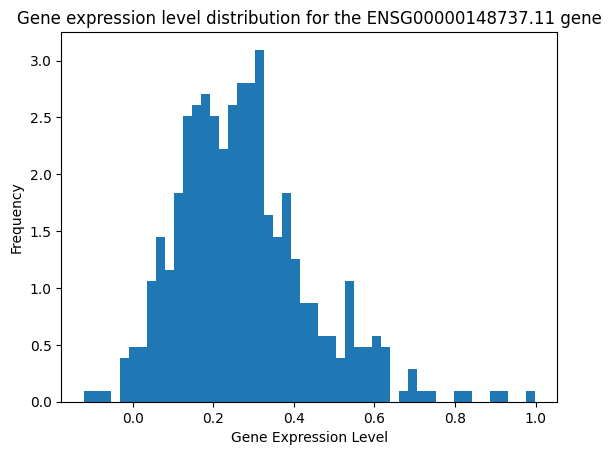

In [16]:
P[P['TargetID']==temp_gene][P.columns[4:]].reset_index(drop=True).T[0].plot(kind='hist', bins=50, density=True)
plt.xlabel('Gene Expression Level')
plt.title(f'Gene expression level distribution for the {temp_gene} gene')
plt.show()